In [1]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 5.2MB/s 


In [2]:
# Importing Libraries

import tensorflow
from tensorflow.python.keras import backend 

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
from keras.utils import np_utils
from keras.optimizers import Adam

import pandas as pd
import matplotlib.pylab as plt

import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

import gzip
import os
import sys
import struct
import numpy as np

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# Extracting Files online
def read_image(fi):
    channel = 1
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns * channel
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns*channel)
    return rawdata.reshape(n, rows, columns, channel).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

In [4]:
# Load the dataset

data = np.load('mnist.npz')

X_train = data['train_x']
y_train = data['train_y']

X_test = data['test_x']
y_test = data['test_y']

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(X_train.shape, X_train.dtype)
print(y_train.shape, y_train.dtype)
print(X_test.shape, X_test.dtype)
print(y_test.shape, y_test.dtype)

(60000, 28, 28, 1) float32
(60000, 10) float32
(10000, 28, 28, 1) float32
(10000, 10) float32


In [0]:
# Build Initial Model

def build_model():
  model = Sequential()
  # add Convolutional layers
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same',
                     input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='sigmoid', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  # Densely connected layers
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10,activation='softmax',name="output_layer"))
  adam = Adam(lr=1e-2, decay= 1e-6)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=["accuracy"])
  return model

In [6]:
# Fit and Evaluate the Model

initial_model = build_model()
initial_model.summary()

initial_cnn_model = initial_model.fit(X_train, y_train, batch_size=128, epochs =4, validation_split=.15)

loss, accuracy = initial_model.evaluate(X_test,y_test)
print('Accuracy = ', accuracy)
print('Loss = ', loss)

y_Predict = initial_model.predict(X_test)

print("Misclassification = ", (np.argmax(y_Predict, axis=1) != np.argmax(y_test,axis=1)).sum())








Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)        

## Hyperparameter Optimization

In [0]:
dim_learning_rate = Real(low=1e-4, high=1e-1, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=3, name='num_dense_layers')
dim_num_input_nodes = Integer(low=32, high=128, name='num_input_nodes')
dim_num_dense_nodes = Integer(low=32, high=128, name='num_dense_nodes')
dim_activation = Categorical(categories=['tanh','sigmoid','relu', 'softmax'],name='activation')
dim_batch_size = Integer(low=64, high=128, name='batch_size')
dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_input_nodes,
              dim_num_dense_nodes,
              dim_activation,
              dim_batch_size,
              dim_adam_decay
             ]
default_parameters = [1e-2, 1,32, 128, 'relu',64, 1e-6]

In [0]:
# Model for Hyperparameter optimization

from keras.optimizers import Adam
def build_model(learning_rate, num_dense_layers,num_input_nodes,num_dense_nodes, 
                 activation, adam_decay):
  model = Sequential()
  # add Convolutional layers
  model.add(Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same',
                     input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation=activation, padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  # Densely connected layers
  model.add(Dense(num_input_nodes, activation=activation))
  for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        model.add(Dense(num_dense_nodes,
                 activation=activation,
                        name=name
                 ))
  model.add(Dense(10,activation='softmax',name="output_layer"))
  #setup our optimizer and compile
  adam = Adam(lr=learning_rate, decay= adam_decay)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=["accuracy"])
  return model

In [0]:
# Perform optimization

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_input_nodes, 
            num_dense_nodes,activation, batch_size,adam_decay):

    model = build_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_input_nodes=num_input_nodes,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         adam_decay=adam_decay
                        )
    

    #named blackbox becuase it represents the structure
    blackbox = model.fit(x=X_train,
                        y=y_train,
                        epochs=3,
                        batch_size=batch_size,
                        validation_split=0.15,
                        )
    
    #return the validation accuracy for the last epoch.
    count = 0
    train_accuracy = blackbox.history['acc'][-1]
    train_loss = blackbox.history['loss'][-1]
    val_accuracy = blackbox.history['val_acc'][-1]
    val_loss = blackbox.history['val_loss'][-1]
  
    # Print the classification accuracy.
    print("Training Accuracy: {0:.2%}".format(train_accuracy))
    print("Training Loss: {0:.2%}".format(train_loss))
    print("Validation Accuracy: {0:.2%}".format(val_accuracy))
    print("Validation Loss: {0:.2%}".format(val_loss))
    print()


    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    backend.clear_session()
    tensorflow.reset_default_graph()
    
    return val_accuracy

In [0]:
backend.clear_session()
tensorflow.reset_default_graph()

In [11]:
gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=15,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=default_parameters)

Train on 51000 samples, validate on 9000 samples
Epoch 1/3
51000/51000 [==============================] - 9s 185us/step - loss: 0.1131 - acc: 0.9669 - val_loss: 0.0795 - val_acc: 0.9790
Epoch 2/3
51000/51000 [==============================] - 9s 178us/step - loss: 0.0852 - acc: 0.9756 - val_loss: 0.0694 - val_acc: 0.9791
Epoch 3/3
51000/51000 [==============================] - 9s 179us/step - loss: 0.0815 - acc: 0.9760 - val_loss: 0.1085 - val_acc: 0.9718
Training Accuracy: 97.60%
Training Loss: 8.15%
Validation Accuracy: 97.18%
Validation Loss: 10.85%

Train on 51000 samples, validate on 9000 samples
Epoch 1/3
51000/51000 [==============================] - 8s 151us/step - loss: 0.0534 - acc: 0.9837 - val_loss: 0.0618 - val_acc: 0.9838
Epoch 2/3
51000/51000 [==============================] - 7s 134us/step - loss: 0.0511 - acc: 0.9850 - val_loss: 0.0670 - val_acc: 0.9840
Epoch 3/3
51000/51000 [==============================] - 7s 138us/step - loss: 0.0526 - acc: 0.9849 - val_loss: 0.073

In [12]:
# Various Hyper Parameters and Accuracy achieved

new_dataframe = [pd.DataFrame(gp_result.x_iters, columns = ["learning rate","hidden layers","input layer nodes","hidden layer nodes",
                                           "activation function","batch size","adam learning rate decay"]),
(pd.Series(gp_result.func_vals*100, name="accuracy"))]
new_dataframe = pd.concat(new_dataframe,axis=1)
new_dataframe

,learning rate,hidden layers,input layer nodes,hidden layer nodes,activation function,batch size,adam learning rate decay,accuracy
0,0.010000,1,32,128,relu,64,0.000001,97.177778
1,0.045077,2,62,77,sigmoid,94,0.008518,98.200000
2,0.000122,2,125,86,relu,80,0.000491,98.477778
3,0.005567,2,127,126,sigmoid,78,0.008573,98.122221
4,0.000574,1,118,80,relu,107,0.003878,98.388889
5,0.003470,1,85,75,relu,127,0.005748,98.277779
6,0.093264,3,80,79,softmax,80,0.002575,98.388890
7,0.000700,3,113,122,tanh,103,0.001856,98.455555
8,0.052584,1,89,43,softmax,108,0.001423,98.455555
9,0.000451,2,90,39,sigmoid,105,0.006394,98.377778


In [13]:
# Model's Best hyperparameters
new_dataframe['accuracy'].max()

98.47777848773532

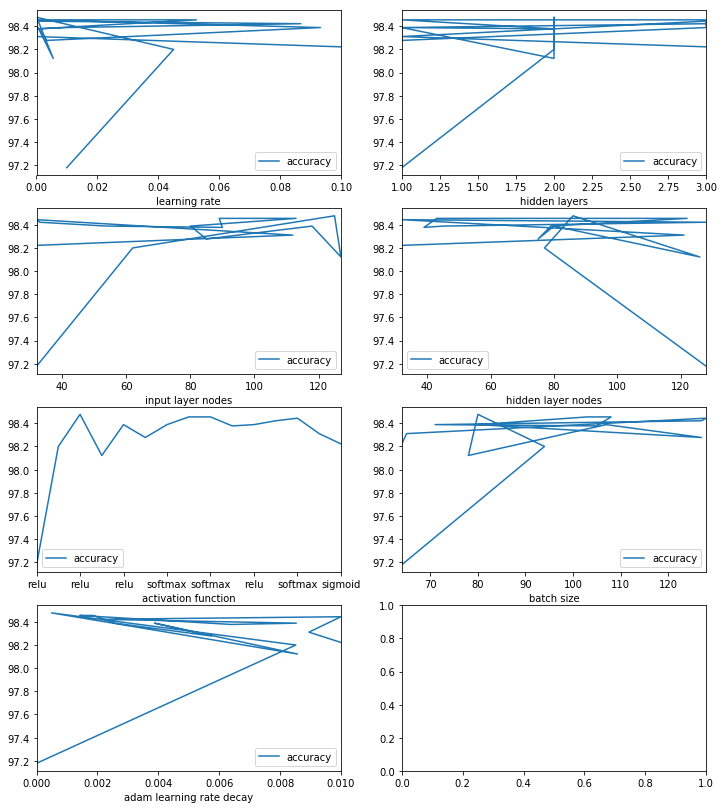

In [14]:
# Data Visualization
%matplotlib inline

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,14))
new_dataframe.plot(x='learning rate', y='accuracy', ax=axes[0,0])
new_dataframe.plot(x='hidden layers', y='accuracy', ax=axes[0,1])
new_dataframe.plot(x='input layer nodes', y='accuracy', ax=axes[1,0])
new_dataframe.plot(x='hidden layer nodes', y='accuracy', ax=axes[1,1])
new_dataframe.plot(x='activation function', y='accuracy', ax=axes[2,0])
new_dataframe.plot(x='batch size', y='accuracy', ax=axes[2,1])
new_dataframe.plot(x='adam learning rate decay', y='accuracy', ax=axes[3,0])